In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
from matplotlib import cm
from alive_progress import alive_bar

# --- 1) Simulation setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hbar = 1.0
# increase mass to slow dispersion
m    = 5.0

Nx, Ny = 2000, 1000
Lx, Ly = 10.0, 10.0
dx, dy = Lx/Nx, Ly/Ny

x = torch.linspace(-Lx/2, Lx/2, Nx, device=device)
y = torch.linspace(-Ly/2, Ly/2, Ny, device=device)
X, Y = torch.meshgrid(x, y, indexing='ij')

dt = 0.0025
n_steps = 12000
snap_every = 5

# --- 1a) Potential with a barrier at  x ∈ (0, 0.5) ---
V = torch.zeros((Nx, Ny), dtype=torch.float32, device=device)
barrier_height = 10.0
V[(X > 0.0) & (X < 0.5)] = barrier_height
V[(X == 5.0) | (X == -5.0) | (Y == 5.0) | (Y == -5.0)] = 100000

# --- 1b) Initial Gaussian wavepacket ---
x0, y0 = -2.0, 0.0
# increase momentum to speed it up
px0, py0 = 10.0, 0.0
# widen initial packet to slow dispersion
sigma = 1.0

psi = (1/(sigma * torch.sqrt(torch.tensor(torch.pi, device=device)))) * \
      torch.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2)) * \
      torch.exp(1j * (px0 * X + py0 * Y) / hbar)
psi = psi / torch.sqrt(torch.sum(torch.abs(psi)**2) * dx * dy)

# k‑space grid
kx = 2 * torch.pi * torch.fft.fftfreq(Nx, d=dx, device=device)
ky = 2 * torch.pi * torch.fft.fftfreq(Ny, d=dy, device=device)
KX, KY = torch.meshgrid(kx, ky, indexing='ij')
KE = (hbar**2) * (KX**2 + KY**2) / (2 * m)

# Precompute phase factors for split‑step (after V is set)
expV  = torch.exp(-1j * V     * dt    / hbar)
expK2 = torch.exp(-1j * KE    * dt/(2*hbar))

# --- 2) Propagate and store snapshots ---
snapshots = []
with alive_bar(n_steps, force_tty=True, title="Propagating") as pbar:
    for i in range(n_steps):
        # half‑step kinetic
        psi = torch.fft.ifftn(expK2 * torch.fft.fftn(psi, dim=(0,1)), dim=(0,1))
        # potential step
        psi = expV * psi
        # half‑step kinetic
        psi = torch.fft.ifftn(expK2 * torch.fft.fftn(psi, dim=(0,1)), dim=(0,1))
        # renormalize
        psi /= torch.sqrt(torch.sum(torch.abs(psi)**2) * dx * dy)

        if i % snap_every == 0:
            prob = torch.abs(psi)**2
            snapshots.append(prob.cpu().numpy())
        pbar()



Propagating |                                        | ▁▃▅ 0/12000 [0%] in 0s (~

Propagating |████████████████████████████████████████| 12000/12000 [100%] in 8.7


on 0: C:\Users\nicol\AppData\Local\Temp\ipykernel_4908\3315161480.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
        cmap = cm.get_cmap('plasma')


Rendering GIF |████████████████████████████████████████| 2400/2400 [100%] in 6:2
3D bar‑plot GIF saved as wavepacket_3d_bars.gif


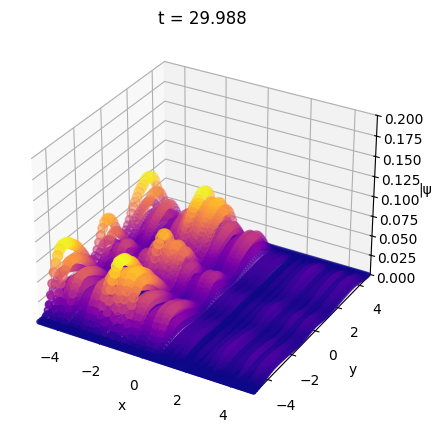

In [4]:
# Transpose each so that X→columns, Y→rows for plotting
snapshots = [s for s in snapshots]

# Precompute global max for fixed z‑axis
Z_max = max(frame.max() for frame in snapshots)

# CPU meshgrids
Xc = X.cpu().numpy()
Yc = Y.cpu().numpy()

# Bar‑plot subsampling step
step = 16
xs = Xc[::step, ::step].flatten()
ys = Yc[::step, ::step].flatten()
zs = np.zeros_like(xs)
dx_bar = dx * step
dy_bar = dy * step

# --- 3) Set up the figure ---
fig = plt.figure(figsize=(6,5))
ax  = fig.add_subplot(111, projection='3d')
ax.set_xlim(-Lx/2, Lx/2)
ax.set_ylim(-Ly/2, Ly/2)
ax.set_zlim(0, Z_max)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('|ψ|²')

# draw initial bars
dz0 = snapshots[0][::step, ::step].flatten()
bars = ax.bar3d(xs, ys, zs, dx_bar, dy_bar, dz0, shade=True)

# --- 4) Update function ---
def update(frame):
    ax.cla()
    dz = snapshots[frame][::step, ::step].flatten()
    current_max = max(dz.max() * 1.05, 0.2)

    ax.set_xlim(-Lx/2, Lx/2)
    ax.set_ylim(-Ly/2, Ly/2)
    ax.set_zlim(0, current_max)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('|ψ|²')
    ax.set_title(f"t = {frame * snap_every * dt:.3f}")

    # normalize for coloring
    if dz.max() > 0:
        normed = dz / dz.max()
    else:
        normed = dz
    cmap = cm.get_cmap('plasma')
    bar_colors = cmap(normed)
    size=10+normed*50
    ax.scatter3D(
        xs, ys, dz,
        # dx_bar, dy_bar, dz,
        c=bar_colors,
        s=size,
        depthshade=True
    )

# --- 5) Render and save as GIF ---
writer = PillowWriter(fps=30)
writer.setup(fig, "wavepacket_3d_bars.gif", dpi=200)

with alive_bar(len(snapshots), force_tty=True, title="Rendering GIF") as bar_anim:
    for i in range(len(snapshots[:])):
        update(i)
        writer.grab_frame()
        bar_anim()

writer.finish()
print("3D bar‑plot GIF saved as wavepacket_3d_bars.gif")
